In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

## Step 1 - Climate Analysis and Exploration

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

## Precipitation Analysis

In [10]:
## precipitation analyis

In [11]:
#  `engine.execute` to select and display the first 10 rows from the measurement table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [12]:
#exploring the most recent and oldest measurement data by date
oldest_meas_date = session.query(Measurement.date).order_by(Measurement.date.asc()).first()
recent_meas_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(oldest_meas_date)
print(recent_meas_date)

('2010-01-01',)
('2017-08-23',)


In [13]:
# Calculate the date 1 year ago from the last data point in the database
meas_one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(meas_one_year_ago)

2016-08-23


In [14]:
ppt_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= meas_one_year_ago).all()      

In [15]:
# dropna to exclude null values
df = pd.DataFrame(ppt_data, columns=['date', 'precipitation']).dropna()
df.set_index('date', inplace=True, )
df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


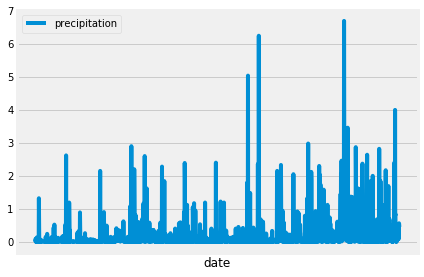

In [16]:
df.plot(x_compat=True)
plt.tight_layout()
plt.xticks([[]])
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station = session.query(Station.station, func.count(Measurement.tobs)).\
filter(Station.station == Measurement.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_records = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
temp_records

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= meas_one_year_ago).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()
# most_tobs

In [22]:

df2 = pd.DataFrame(most_tobs, columns=['date', 'tobs']).dropna() 
df2.set_index('date', inplace=True, )
df2.head(10)

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
2016-08-29,78.0
2016-08-30,77.0
2016-08-31,78.0


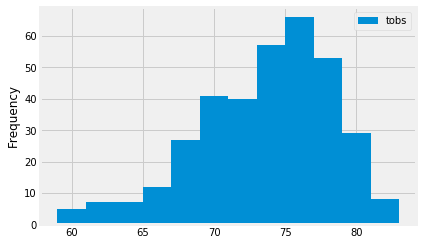

In [23]:
x = most_tobs
df2.plot.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()

## Step 2 - Climate App

## Optional: Other Recommended Analyses

In [24]:
#The following are optional challenge queries. 
#These are highly recommended to attempt, but not required for the homework.

## Temperature Analysis

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
#trip_arrive = dt.date(2018, 7, 1)
#trip_leave = dt.date(2018, 7, 15)
#last_year = dt.timedelta(days=365)
#temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
#print(temp_avg_lst_year)

In [27]:
#min_trip_temp =temp_avg_lst_year[0][0]
#min_trip_temp

In [28]:
#max_trip_temp = temp_avg_lst_year[0][1]
#max_trip_temp

In [29]:
#avg_trip_temp = temp_avg_lst_year[0][1]
#avg_trip_temp

In [30]:
#plt.figure(figsize=(2,5))
#plt.bar(0,avg_trip_temp,yerr=[max_trip_temp-min_trip_temp],color='orange')
#plt.title('Trip Avg Temp')
#plt.xticks([])
#plt.ylim(0,100)


In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Daily Rainfall Average

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [36]:
# Plot the daily normals as an area plot with `stacked=False`
